# NDS Distinguishability on 1-WL-Equivalent Graph Pairs: Comprehensive Ablation Study

This notebook demonstrates **Nonlinear Diffusion Signatures (NDS)** — a method for distinguishing 1-WL-equivalent graph pairs that are provably indistinguishable by the 1-dimensional Weisfeiler-Leman (1-WL) test.

**Key idea:** Interleaving pointwise nonlinearities (ReLU, tanh, abs, square) between diffusion steps creates cross-frequency coupling that breaks spectral invariance, potentially enabling distinction of graphs that linear diffusion alone cannot separate.

**What this demo does:**
- Loads verified 1-WL-equivalent graph pairs (SRG-16, SRG-25, SRG-26, CSL-41)
- Computes NDS features across multiple configurations (nonlinearities × initializations × diffusion steps)
- Measures distinguishability via exact multiset match, Frobenius distance, and MMD-RBF
- Compares trajectory-based vs. single-step distinguishability

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import hashlib
import time
from typing import Any, Callable

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

## Data Loading

Loads graph pair data from GitHub (falls back to local file).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter2_nds_distinguish/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'][0]['examples'])} graph pairs")
print(f"Categories: {data['metadata']['categories']}")

Loaded 5 graph pairs
Categories: ['srg_16_6_2_2', 'srg_25_12_5_6', 'srg_26_10_3_4', 'csl_41']


## Configuration

All tunable parameters for the NDS ablation study. Adjust these to control experiment scope and runtime.

In [5]:
# --- Tunable parameters ---
# Diffusion steps to test (original: list(range(0, 21)))
T_VALUES = list(range(0, 21))

# Maximum number of graph pairs to process (original: all pairs in data)
MAX_PAIRS = 5

# Nonlinearity functions
NONLINEARITIES: dict[str, Callable[[np.ndarray], np.ndarray]] = {
    "linear": lambda x: x,
    "relu": lambda x: np.maximum(x, 0),
    "tanh": lambda x: np.tanh(x),
    "abs": lambda x: np.abs(x),
    "square": lambda x: x ** 2,
}

# Extra nonlinearities for extended analysis
EXTRA_NONLINEARITIES: dict[str, Callable[[np.ndarray], np.ndarray]] = {
    "leaky_relu": lambda x: np.where(x > 0, x, 0.01 * x),
    "softplus": lambda x: np.log1p(np.exp(np.clip(x, -50, 50))),
}

# Initialization strategies
INIT_STRATEGIES = ["degree", "adjacency_row", "random"]

# Diffusion operators
DIFFUSION_OPERATORS = ["symmetric_norm", "row_norm", "unnormalized", "laplacian"]

# T subset for extended phases (phase 4 & 5)
T_SUBSET = [0, 1, 2, 3, 5, 10, 15, 20]

# Alternative diffusion operators for phase 5
ALT_OPS = ["row_norm", "unnormalized", "laplacian"]

print(f"Config: T_VALUES={len(T_VALUES)} steps, MAX_PAIRS={MAX_PAIRS}")
print(f"Main grid: {MAX_PAIRS} pairs × {len(NONLINEARITIES)} nonlins × {len(INIT_STRATEGIES)} inits × {len(T_VALUES)} T values")
total = MAX_PAIRS * len(NONLINEARITIES) * len(INIT_STRATEGIES) * len(T_VALUES)
print(f"Total main configs: {total}")

Config: T_VALUES=21 steps, MAX_PAIRS=5
Main grid: 5 pairs × 5 nonlins × 3 inits × 21 T values
Total main configs: 1575


## Step 1: Data Loading — Parse Graph Pairs

Extract adjacency matrices from the loaded JSON data and perform sanity checks.

In [6]:
def load_graph_pairs(data: dict) -> list[dict[str, Any]]:
    """Load all graph pairs from the dataset JSON."""
    examples = data["datasets"][0]["examples"]
    print(f"Found {len(examples)} graph pairs")

    pairs = []
    for ex in examples[:MAX_PAIRS]:
        inp = json.loads(ex["input"])
        adj_a = np.array(inp["graph_a"]["adjacency_matrix"], dtype=np.float64)
        adj_b = np.array(inp["graph_b"]["adjacency_matrix"], dtype=np.float64)
        n = adj_a.shape[0]

        # Sanity checks
        assert adj_a.shape == (n, n), f"adj_a shape mismatch: {adj_a.shape}"
        assert adj_b.shape == (n, n), f"adj_b shape mismatch: {adj_b.shape}"
        assert np.allclose(adj_a, adj_a.T), f"adj_a not symmetric for {inp['pair_id']}"
        assert np.allclose(adj_b, adj_b.T), f"adj_b not symmetric for {inp['pair_id']}"
        assert np.allclose(np.diag(adj_a), 0), f"adj_a non-zero diagonal for {inp['pair_id']}"
        assert np.allclose(np.diag(adj_b), 0), f"adj_b non-zero diagonal for {inp['pair_id']}"

        pairs.append({
            "pair_id": inp["pair_id"],
            "category": inp["category"],
            "adj_a": adj_a,
            "adj_b": adj_b,
            "n": n,
            "num_edges_a": int(adj_a.sum()) // 2,
            "num_edges_b": int(adj_b.sum()) // 2,
            "example": ex,
            "graph_a_name": inp["graph_a"]["name"],
            "graph_b_name": inp["graph_b"]["name"],
        })
        print(
            f"  Pair {inp['pair_id']}: n={n}, "
            f"edges_a={int(adj_a.sum())//2}, edges_b={int(adj_b.sum())//2}, "
            f"category={inp['category']}"
        )

    return pairs

pairs = load_graph_pairs(data)

Found 5 graph pairs
  Pair srg16_rook_vs_shrikhande: n=16, edges_a=48, edges_b=48, category=srg_16_6_2_2
  Pair srg25_paulus_g1_vs_g2: n=25, edges_a=150, edges_b=150, category=srg_25_12_5_6
  Pair srg26_paulus_g1_vs_g2: n=26, edges_a=130, edges_b=130, category=srg_26_10_3_4
  Pair csl41_skip2_vs_skip3: n=41, edges_a=82, edges_b=82, category=csl_41
  Pair csl41_skip6_vs_skip9: n=41, edges_a=82, edges_b=82, category=csl_41


## Step 2: Core NDS Computation

Defines diffusion operators, feature initialization, safe normalization, and the NDS trajectory computation.

In [7]:
def compute_diffusion_operator(
    adj: np.ndarray,
    operator_type: str = "symmetric_norm",
) -> np.ndarray:
    """
    Compute diffusion operator from adjacency matrix.

    Parameters
    ----------
    adj : np.ndarray
        (n, n) adjacency matrix.
    operator_type : str
        One of 'symmetric_norm', 'row_norm', 'unnormalized', 'laplacian'.

    Returns
    -------
    np.ndarray
        (n, n) dense diffusion operator matrix.
    """
    n = adj.shape[0]
    deg = adj.sum(axis=1)

    if operator_type == "symmetric_norm":
        # D^{-1/2} A D^{-1/2}
        d_inv_sqrt = np.zeros(n)
        nonzero = deg > 0
        d_inv_sqrt[nonzero] = 1.0 / np.sqrt(deg[nonzero])
        D_inv_sqrt = np.diag(d_inv_sqrt)
        return D_inv_sqrt @ adj @ D_inv_sqrt

    elif operator_type == "row_norm":
        # D^{-1} A  (random walk normalization)
        d_inv = np.zeros(n)
        nonzero = deg > 0
        d_inv[nonzero] = 1.0 / deg[nonzero]
        D_inv = np.diag(d_inv)
        return D_inv @ adj

    elif operator_type == "unnormalized":
        return adj.copy()

    elif operator_type == "laplacian":
        # I - D^{-1/2} A D^{-1/2}
        d_inv_sqrt = np.zeros(n)
        nonzero = deg > 0
        d_inv_sqrt[nonzero] = 1.0 / np.sqrt(deg[nonzero])
        D_inv_sqrt = np.diag(d_inv_sqrt)
        A_norm = D_inv_sqrt @ adj @ D_inv_sqrt
        return np.eye(n) - A_norm

    else:
        raise ValueError(f"Unknown operator type: {operator_type}")


def init_features(
    adj: np.ndarray,
    strategy: str,
) -> np.ndarray:
    """
    Initialize node features based on strategy.

    Parameters
    ----------
    adj : np.ndarray
        (n, n) adjacency matrix.
    strategy : str
        One of 'degree', 'adjacency_row', 'random'.

    Returns
    -------
    np.ndarray
        (n,) or (n, d) initial feature matrix.
    """
    n = adj.shape[0]

    if strategy == "degree":
        return adj.sum(axis=1).astype(np.float64)  # (n,)

    elif strategy == "adjacency_row":
        return adj.astype(np.float64)  # (n, n)

    elif strategy == "random":
        rng = np.random.RandomState(42)
        return rng.randn(n).astype(np.float64)  # (n,)

    else:
        raise ValueError(f"Unknown init strategy: {strategy}")


def _safe_normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalize features to prevent numerical overflow.

    Divides by the max absolute value (row-wise for 2D, globally for 1D)
    when values exceed a threshold. This preserves relative differences
    between feature vectors while keeping values in a numerically stable range.
    """
    max_val = np.max(np.abs(x))
    if max_val > 1e30 or np.any(np.isinf(x)) or np.any(np.isnan(x)):
        # Replace inf/nan with 0, then normalize
        x = np.where(np.isfinite(x), x, 0.0)
        max_val = np.max(np.abs(x))
        if max_val > 0:
            x = x / max_val
    return x


def compute_nds(
    diffusion_op: np.ndarray,
    x0: np.ndarray,
    nonlinearity_fn: Callable[[np.ndarray], np.ndarray],
    T: int,
    normalize: bool = True,
) -> np.ndarray:
    """
    Compute NDS trajectory.

    Parameters
    ----------
    diffusion_op : np.ndarray
        (n, n) diffusion operator.
    x0 : np.ndarray
        (n,) or (n, d) initial features.
    nonlinearity_fn : callable
        Pointwise nonlinearity.
    T : int
        Number of diffusion-nonlinearity rounds.
    normalize : bool
        Whether to normalize features after each step to prevent overflow.

    Returns
    -------
    np.ndarray
        (n, cols) trajectory matrix.
        For 1D init: (n, T+1).
        For 2D init: (n, d*(T+1)).
    """
    trajectory = [x0.copy()]
    x = x0.copy()

    for _ in range(T):
        x = diffusion_op @ x  # diffusion step
        x = nonlinearity_fn(x)  # nonlinearity step
        if normalize:
            x = _safe_normalize(x)
        trajectory.append(x.copy())

    if x0.ndim == 1:
        return np.column_stack(trajectory)  # (n, T+1)
    else:
        return np.concatenate(trajectory, axis=1)  # (n, d*(T+1))


def compute_nds_final_step(
    diffusion_op: np.ndarray,
    x0: np.ndarray,
    nonlinearity_fn: Callable[[np.ndarray], np.ndarray],
    T: int,
    normalize: bool = True,
) -> np.ndarray:
    """
    Compute NDS features at ONLY step T (not the full trajectory).

    This is useful for analyzing whether the nonlinearity helps at each
    individual diffusion step, separate from the trajectory accumulation.
    """
    x = x0.copy()
    for _ in range(T):
        x = diffusion_op @ x
        x = nonlinearity_fn(x)
        if normalize:
            x = _safe_normalize(x)
    return x

print("Core NDS functions defined.")

Core NDS functions defined.


## Step 3: Distinguishability Metrics

Three metrics to measure graph distinguishability:
- **Exact multiset match:** Do sorted NDS rows match within tolerance?
- **Frobenius distance:** How far apart are the sorted NDS matrices?
- **MMD-RBF:** Maximum Mean Discrepancy with RBF kernel between row distributions.

In [8]:
def _sanitize_matrix(X: np.ndarray) -> np.ndarray:
    """Replace inf/nan with 0 to prevent comparison failures."""
    return np.where(np.isfinite(X), X, 0.0)


def sort_rows_lexicographic(X: np.ndarray, decimals: int = 10) -> np.ndarray:
    """Sort rows of X lexicographically after rounding."""
    X_clean = _sanitize_matrix(X)
    X_rounded = np.round(X_clean, decimals)
    if X_rounded.ndim == 1:
        X_rounded = X_rounded.reshape(-1, 1)
    # Lexicographic sort: sort by last column first, then second last, etc.
    indices = np.lexsort(X_rounded.T[::-1])
    return X_rounded[indices]


def exact_multiset_match(nds_a: np.ndarray, nds_b: np.ndarray, tol: float = 1e-8) -> bool:
    """Check if sorted NDS feature matrices are identical within tolerance."""
    sorted_a = sort_rows_lexicographic(nds_a)
    sorted_b = sort_rows_lexicographic(nds_b)
    return bool(np.allclose(sorted_a, sorted_b, atol=tol))


def frobenius_distance(nds_a: np.ndarray, nds_b: np.ndarray) -> float:
    """Frobenius norm of difference between sorted feature matrices."""
    sorted_a = sort_rows_lexicographic(nds_a)
    sorted_b = sort_rows_lexicographic(nds_b)
    return float(np.linalg.norm(sorted_a - sorted_b))


def compute_mmd_rbf(X: np.ndarray, Y: np.ndarray, bandwidth: float | None = None) -> float:
    """
    Compute MMD^2 with RBF kernel between two sets of row vectors.

    Parameters
    ----------
    X, Y : np.ndarray
        (n, d) feature matrices.
    bandwidth : float or None
        RBF bandwidth. If None, uses median heuristic.

    Returns
    -------
    float
        MMD^2 value.
    """
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)

    # Sanitize inputs
    X = _sanitize_matrix(X)
    Y = _sanitize_matrix(Y)

    if bandwidth is None:
        all_pts = np.vstack([X, Y])
        all_dists = cdist(all_pts, all_pts, "sqeuclidean")
        pos_dists = all_dists[all_dists > 0]
        if len(pos_dists) == 0:
            bandwidth = 1.0
        else:
            bandwidth = float(np.sqrt(np.median(pos_dists)))
        if bandwidth < 1e-12:
            bandwidth = 1.0

    gamma = 1.0 / (2.0 * bandwidth ** 2)

    # Clip exponent arguments to prevent underflow to exactly 0
    d_xx = cdist(X, X, "sqeuclidean")
    d_yy = cdist(Y, Y, "sqeuclidean")
    d_xy = cdist(X, Y, "sqeuclidean")

    K_xx = np.exp(-gamma * np.clip(d_xx, 0, 500 / max(gamma, 1e-12)))
    K_yy = np.exp(-gamma * np.clip(d_yy, 0, 500 / max(gamma, 1e-12)))
    K_xy = np.exp(-gamma * np.clip(d_xy, 0, 500 / max(gamma, 1e-12)))

    mmd2 = float(K_xx.mean() + K_yy.mean() - 2.0 * K_xy.mean())
    return mmd2


def graph_level_hash(nds: np.ndarray, decimals: int = 8) -> str:
    """Compute hash of sorted, rounded feature matrix (NaN/inf safe)."""
    sorted_m = sort_rows_lexicographic(nds, decimals=decimals)
    return hashlib.sha256(sorted_m.tobytes()).hexdigest()

print("Distinguishability metrics defined.")

Distinguishability metrics defined.


## Step 4: Self-Consistency Check

Verify that NDS produces identical features when comparing a graph to itself (sanity check).

In [9]:
def self_consistency_check(pairs: list[dict]) -> None:
    """Verify NDS gives identical features when comparing a graph to itself."""
    pair = pairs[0]
    adj = pair["adj_a"]
    diff_op = compute_diffusion_operator(adj, operator_type="symmetric_norm")
    x0 = init_features(adj, strategy="adjacency_row")
    nds = compute_nds(
        diffusion_op=diff_op,
        x0=x0,
        nonlinearity_fn=NONLINEARITIES["relu"],
        T=10,
    )
    frob = frobenius_distance(nds, nds)
    is_match = exact_multiset_match(nds, nds)
    print(f"Self-consistency check: frob={frob:.2e}, match={is_match}")
    assert frob < 1e-12, f"Self-consistency FAILED: frob={frob}"
    assert is_match, "Self-consistency FAILED: multiset mismatch"
    print("Self-consistency check PASSED ✓")

self_consistency_check(pairs)

Self-consistency check: frob=0.00e+00, match=True
Self-consistency check PASSED ✓


## Step 5: Main Experiment Loop

Run the full ablation study across all pairs × nonlinearities × initializations × diffusion steps. Includes extended analysis with extra nonlinearities and alternative diffusion operators.

In [10]:
def run_single_config(
    pair: dict,
    nonlin_name: str,
    init_name: str,
    T: int,
    diffusion_type: str = "symmetric_norm",
) -> dict[str, Any]:
    """Run NDS for one (pair, nonlinearity, init, T, diffusion_type) config."""
    adj_a = pair["adj_a"]
    adj_b = pair["adj_b"]

    # Select nonlinearity
    all_nonlins = {**NONLINEARITIES, **EXTRA_NONLINEARITIES}
    nonlin_fn = all_nonlins[nonlin_name]

    # Compute diffusion operators
    diff_op_a = compute_diffusion_operator(adj_a, operator_type=diffusion_type)
    diff_op_b = compute_diffusion_operator(adj_b, operator_type=diffusion_type)

    # Initialize features
    x0_a = init_features(adj_a, strategy=init_name)
    x0_b = init_features(adj_b, strategy=init_name)

    # Compute full NDS trajectory
    nds_a = compute_nds(diff_op_a, x0_a, nonlin_fn, T)
    nds_b = compute_nds(diff_op_b, x0_b, nonlin_fn, T)

    # Trajectory-based metrics (all steps concatenated)
    is_identical = exact_multiset_match(nds_a, nds_b)
    distinguished = not is_identical
    frob = frobenius_distance(nds_a, nds_b)
    mmd = compute_mmd_rbf(nds_a, nds_b)
    hash_a = graph_level_hash(nds_a)
    hash_b = graph_level_hash(nds_b)
    hash_distinguished = hash_a != hash_b

    # Single-step metrics (features at ONLY step T, not trajectory)
    if T > 0:
        final_a = compute_nds_final_step(diff_op_a, x0_a, nonlin_fn, T)
        final_b = compute_nds_final_step(diff_op_b, x0_b, nonlin_fn, T)
        step_distinguished = not exact_multiset_match(final_a, final_b)
        step_frob = frobenius_distance(final_a, final_b)
    else:
        # T=0 means just the initial features
        step_distinguished = not exact_multiset_match(x0_a, x0_b)
        step_frob = frobenius_distance(x0_a, x0_b)

    return {
        "pair_id": pair["pair_id"],
        "category": pair["category"],
        "nonlinearity": nonlin_name,
        "init": init_name,
        "T": T,
        "diffusion_type": diffusion_type,
        "distinguished": distinguished,
        "frobenius_distance": frob,
        "mmd_rbf": mmd,
        "hash_distinguished": hash_distinguished,
        "step_distinguished": step_distinguished,
        "step_frobenius": step_frob,
        "num_nodes": pair["n"],
        "num_edges": pair["num_edges_a"],
    }


def run_experiment(pairs: list[dict]) -> list[dict[str, Any]]:
    """Run the full ablation experiment."""
    t0 = time.time()

    nonlinearities_main = list(NONLINEARITIES.keys())  # 5 main

    total_configs = len(pairs) * len(nonlinearities_main) * len(INIT_STRATEGIES) * len(T_VALUES)
    print(f"Main grid: {len(pairs)} pairs x {len(nonlinearities_main)} nonlins "
          f"x {len(INIT_STRATEGIES)} inits x {len(T_VALUES)} T values = {total_configs}")

    # Phase 1: Quick sanity — one pair, one config
    print("--- Phase 1: Single-pair sanity check ---")
    test_result = run_single_config(
        pair=pairs[0],
        nonlin_name="relu",
        init_name="adjacency_row",
        T=5,
        diffusion_type="symmetric_norm",
    )
    print(
        f"Sanity result: pair={test_result['pair_id']}, relu/adj_row/T=5 -> "
        f"distinguished={test_result['distinguished']}, "
        f"frob={test_result['frobenius_distance']:.6e}, "
        f"mmd={test_result['mmd_rbf']:.6e}"
    )
    print(f"Phase 1 time: {time.time() - t0:.2f}s")

    # Phase 2: All pairs with relu + adjacency_row, T=5
    print("--- Phase 2: All pairs, relu/adj_row/T=5 ---")
    phase2_results = []
    for pair in pairs:
        r = run_single_config(
            pair=pair,
            nonlin_name="relu",
            init_name="adjacency_row",
            T=5,
            diffusion_type="symmetric_norm",
        )
        phase2_results.append(r)
        print(f"  {r['pair_id']}: distinguished={r['distinguished']}, frob={r['frobenius_distance']:.6e}")
    n_dist = sum(1 for r in phase2_results if r["distinguished"])
    print(f"Phase 2: {n_dist}/{len(pairs)} pairs distinguished. Time: {time.time() - t0:.2f}s")

    # Phase 3: Full main grid
    print("--- Phase 3: Full main grid ---")
    results: list[dict[str, Any]] = []
    count = 0

    for pair in pairs:
        for init_name in INIT_STRATEGIES:
            for nonlin_name in nonlinearities_main:
                for T in T_VALUES:
                    r = run_single_config(
                        pair=pair,
                        nonlin_name=nonlin_name,
                        init_name=init_name,
                        T=T,
                        diffusion_type="symmetric_norm",
                    )
                    results.append(r)
                    count += 1

        print(f"  Completed pair {pair['pair_id']} ({count}/{total_configs})")

    print(f"Phase 3 complete: {count} configs in {time.time() - t0:.2f}s")

    # Phase 4: Extra nonlinearities on best init
    print("--- Phase 4: Extra nonlinearities (leaky_relu, softplus) ---")
    extra_nonlins = list(EXTRA_NONLINEARITIES.keys())
    for pair in pairs:
        for nonlin_name in extra_nonlins:
            for T in T_SUBSET:
                r = run_single_config(
                    pair=pair,
                    nonlin_name=nonlin_name,
                    init_name="adjacency_row",
                    T=T,
                    diffusion_type="symmetric_norm",
                )
                results.append(r)

    print(f"Phase 4 complete. Total results: {len(results)}. Time: {time.time() - t0:.2f}s")

    # Phase 5: Alternative diffusion operators
    print("--- Phase 5: Alternative diffusion operators ---")
    for pair in pairs:
        for diff_type in ALT_OPS:
            for T in T_SUBSET:
                r = run_single_config(
                    pair=pair,
                    nonlin_name="relu",
                    init_name="adjacency_row",
                    T=T,
                    diffusion_type=diff_type,
                )
                results.append(r)

    total_time = time.time() - t0
    print(f"Phase 5 complete. Total results: {len(results)}. Time: {total_time:.2f}s")

    return results

results = run_experiment(pairs)

Main grid: 5 pairs x 5 nonlins x 3 inits x 21 T values = 1575
--- Phase 1: Single-pair sanity check ---
Sanity result: pair=srg16_rook_vs_shrikhande, relu/adj_row/T=5 -> distinguished=True, frob=9.983727e+00, mmd=2.808951e-03
Phase 1 time: 0.00s
--- Phase 2: All pairs, relu/adj_row/T=5 ---
  srg16_rook_vs_shrikhande: distinguished=True, frob=9.983727e+00
  srg25_paulus_g1_vs_g2: distinguished=True, frob=9.207996e+00
  srg26_paulus_g1_vs_g2: distinguished=True, frob=5.699406e+00
  csl41_skip2_vs_skip3: distinguished=True, frob=2.113722e+01
  csl41_skip6_vs_skip9: distinguished=True, frob=2.425057e+01
Phase 2: 5/5 pairs distinguished. Time: 0.10s
--- Phase 3: Full main grid ---


  Completed pair srg16_rook_vs_shrikhande (315/1575)


  Completed pair srg25_paulus_g1_vs_g2 (630/1575)


  Completed pair srg26_paulus_g1_vs_g2 (945/1575)


  Completed pair csl41_skip2_vs_skip3 (1260/1575)


  Completed pair csl41_skip6_vs_skip9 (1575/1575)
Phase 3 complete: 1575 configs in 39.39s
--- Phase 4: Extra nonlinearities (leaky_relu, softplus) ---


Phase 4 complete. Total results: 1655. Time: 41.14s
--- Phase 5: Alternative diffusion operators ---


Phase 5 complete. Total results: 1775. Time: 43.64s


## Step 6: Summary Statistics & Analysis

Compute and display summary statistics from the experiment results.

In [11]:
def compute_summary(results: list[dict[str, Any]]) -> dict[str, Any]:
    """Compute summary statistics from experiment results."""

    # Filter to main grid only (symmetric_norm, main 5 nonlinearities)
    main_nonlins = set(NONLINEARITIES.keys())
    main_results = [
        r for r in results
        if r["diffusion_type"] == "symmetric_norm" and r["nonlinearity"] in main_nonlins
    ]

    # --- Per (nonlinearity, init) at T=10: how many pairs distinguished? ---
    summary_table: dict[str, dict[str, int]] = {}
    for init_name in INIT_STRATEGIES:
        for nonlin_name in main_nonlins:
            key = f"{nonlin_name}/{init_name}"
            count = sum(
                1 for r in main_results
                if r["nonlinearity"] == nonlin_name
                and r["init"] == init_name
                and r["T"] == 10
                and r["distinguished"]
            )
            summary_table[key] = {"pairs_distinguished_at_T10": count}

    # --- Best config ---
    best_config = max(summary_table.items(), key=lambda x: x[1]["pairs_distinguished_at_T10"])
    best_config_name = best_config[0]
    best_config_count = best_config[1]["pairs_distinguished_at_T10"]

    # --- Linear baseline count ---
    linear_degree_count = sum(
        1 for r in main_results
        if r["nonlinearity"] == "linear" and r["init"] == "degree"
        and r["T"] == 10 and r["distinguished"]
    )
    linear_adj_count = sum(
        1 for r in main_results
        if r["nonlinearity"] == "linear" and r["init"] == "adjacency_row"
        and r["T"] == 10 and r["distinguished"]
    )

    # --- Nonlinearity comparison at T=10, adjacency_row (TRAJECTORY-based) ---
    nonlin_comparison: dict[str, int] = {}
    for nonlin_name in main_nonlins:
        c = sum(
            1 for r in main_results
            if r["nonlinearity"] == nonlin_name
            and r["init"] == "adjacency_row"
            and r["T"] == 10
            and r["distinguished"]
        )
        nonlin_comparison[nonlin_name] = c

    # --- Single-step comparison at T=10, adjacency_row ---
    step_nonlin_comparison: dict[str, int] = {}
    for nonlin_name in main_nonlins:
        c = sum(
            1 for r in main_results
            if r["nonlinearity"] == nonlin_name
            and r["init"] == "adjacency_row"
            and r["T"] == 10
            and r["step_distinguished"]
        )
        step_nonlin_comparison[nonlin_name] = c

    # --- Average frobenius distance per nonlinearity (adj_row, T=10) ---
    frob_by_nonlin: dict[str, float] = {}
    for nonlin_name in main_nonlins:
        frobs = [
            r["frobenius_distance"] for r in main_results
            if r["nonlinearity"] == nonlin_name
            and r["init"] == "adjacency_row"
            and r["T"] == 10
        ]
        frob_by_nonlin[nonlin_name] = float(np.mean(frobs)) if frobs else 0.0

    # --- Minimum T per pair for relu/adj_row ---
    min_T_per_pair: dict[str, int | None] = {}
    for r in main_results:
        if r["nonlinearity"] == "relu" and r["init"] == "adjacency_row" and r["diffusion_type"] == "symmetric_norm":
            pid = r["pair_id"]
            if r["distinguished"]:
                prev = min_T_per_pair.get(pid)
                if prev is None or r["T"] < prev:
                    min_T_per_pair[pid] = r["T"]
            else:
                if pid not in min_T_per_pair:
                    min_T_per_pair[pid] = None

    return {
        "pairs_distinguished_by_best_nds_config": best_config_count,
        "best_nds_config": best_config_name,
        "pairs_distinguished_by_linear_baseline_degree": linear_degree_count,
        "pairs_distinguished_by_linear_baseline_adj_row": linear_adj_count,
        "nonlinearity_comparison_trajectory_T10_adj_row": nonlin_comparison,
        "nonlinearity_comparison_single_step_T10_adj_row": step_nonlin_comparison,
        "avg_frobenius_trajectory_by_nonlin_T10_adj_row": frob_by_nonlin,
        "min_T_relu_adj_row_per_pair": {k: v for k, v in min_T_per_pair.items()},
        "summary_table": summary_table,
    }

summary = compute_summary(results)

# Print key findings
print("=" * 60)
print("KEY FINDINGS")
print("=" * 60)
print(f"Best NDS config (trajectory): {summary['best_nds_config']}")
print(f"Pairs distinguished by best NDS: {summary['pairs_distinguished_by_best_nds_config']}/{len(pairs)}")
print(f"Pairs distinguished by linear (degree): {summary['pairs_distinguished_by_linear_baseline_degree']}/{len(pairs)}")
print(f"Pairs distinguished by linear (adj_row): {summary['pairs_distinguished_by_linear_baseline_adj_row']}/{len(pairs)}")
print(f"\nTrajectory nonlin comparison (adj_row, T=10): {summary['nonlinearity_comparison_trajectory_T10_adj_row']}")
print(f"Single-step nonlin comparison (adj_row, T=10): {summary['nonlinearity_comparison_single_step_T10_adj_row']}")
print(f"\nMin T (relu/adj_row): {summary['min_T_relu_adj_row_per_pair']}")
print(f"Total results: {len(results)}")

KEY FINDINGS
Best NDS config (trajectory): relu/adjacency_row
Pairs distinguished by best NDS: 5/5
Pairs distinguished by linear (degree): 0/5
Pairs distinguished by linear (adj_row): 5/5

Trajectory nonlin comparison (adj_row, T=10): {'relu': 5, 'abs': 5, 'tanh': 5, 'linear': 5, 'square': 5}
Single-step nonlin comparison (adj_row, T=10): {'relu': 3, 'abs': 3, 'tanh': 3, 'linear': 3, 'square': 0}

Min T (relu/adj_row): {'srg16_rook_vs_shrikhande': 0, 'srg25_paulus_g1_vs_g2': 0, 'srg26_paulus_g1_vs_g2': 0, 'csl41_skip2_vs_skip3': 0, 'csl41_skip6_vs_skip9': 0}
Total results: 1775


## Visualization

Plot key results: (1) Frobenius distance vs. diffusion steps for each nonlinearity, (2) distinguishability heatmap across nonlinearity × initialization at T=10.

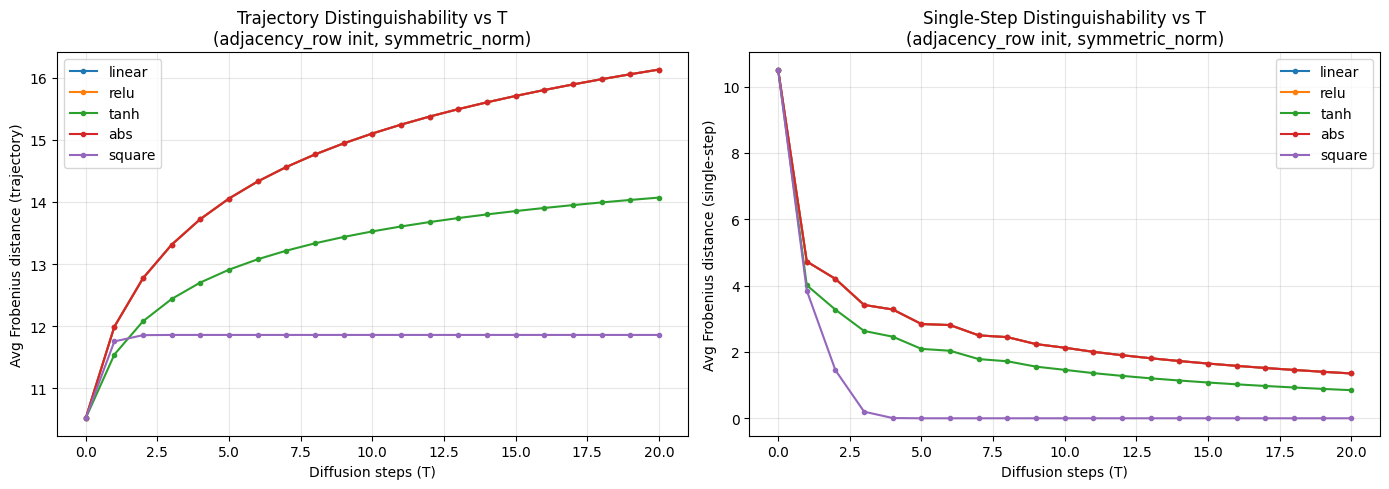

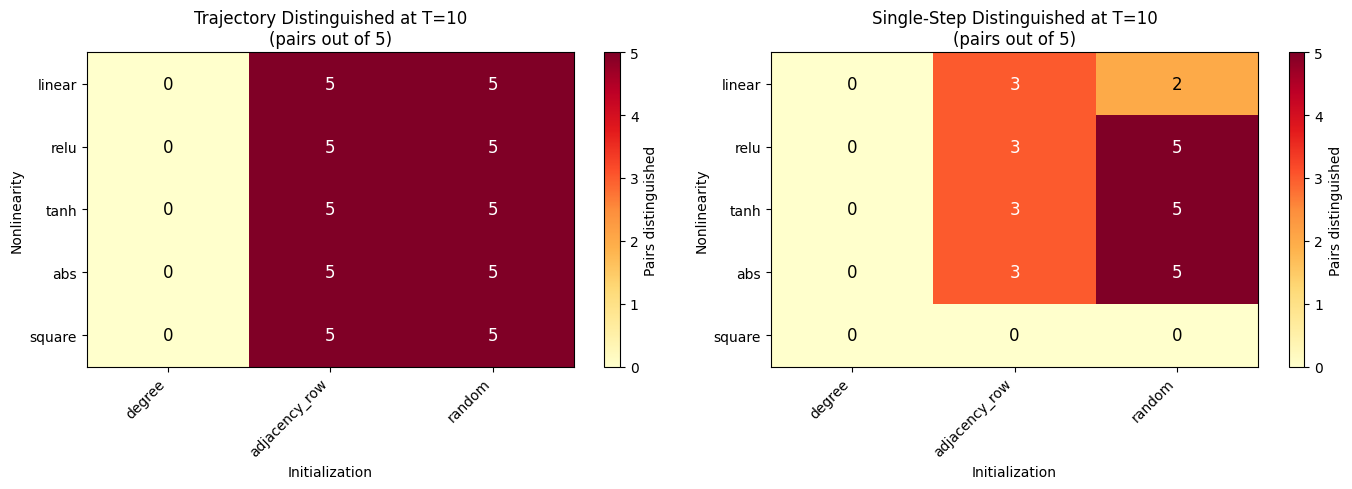


Total experiment results: 1775 configurations tested


In [12]:
# --- Plot 1: Average Frobenius distance vs T for each nonlinearity (adjacency_row init, symmetric_norm) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter to main grid results
main_nonlins = list(NONLINEARITIES.keys())
main_results = [
    r for r in results
    if r["diffusion_type"] == "symmetric_norm" and r["nonlinearity"] in main_nonlins
]

# Plot 1a: Trajectory Frobenius distance vs T
ax = axes[0]
for nonlin_name in main_nonlins:
    avg_frobs = []
    for T in T_VALUES:
        frobs = [
            r["frobenius_distance"] for r in main_results
            if r["nonlinearity"] == nonlin_name
            and r["init"] == "adjacency_row"
            and r["T"] == T
        ]
        avg_frobs.append(np.mean(frobs) if frobs else 0.0)
    ax.plot(T_VALUES, avg_frobs, marker="o", markersize=3, label=nonlin_name)

ax.set_xlabel("Diffusion steps (T)")
ax.set_ylabel("Avg Frobenius distance (trajectory)")
ax.set_title("Trajectory Distinguishability vs T\n(adjacency_row init, symmetric_norm)")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 1b: Single-step Frobenius distance vs T
ax = axes[1]
for nonlin_name in main_nonlins:
    avg_frobs = []
    for T in T_VALUES:
        frobs = [
            r["step_frobenius"] for r in main_results
            if r["nonlinearity"] == nonlin_name
            and r["init"] == "adjacency_row"
            and r["T"] == T
        ]
        avg_frobs.append(np.mean(frobs) if frobs else 0.0)
    ax.plot(T_VALUES, avg_frobs, marker="o", markersize=3, label=nonlin_name)

ax.set_xlabel("Diffusion steps (T)")
ax.set_ylabel("Avg Frobenius distance (single-step)")
ax.set_title("Single-Step Distinguishability vs T\n(adjacency_row init, symmetric_norm)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("frobenius_vs_T.png", dpi=100, bbox_inches="tight")
plt.show()

# --- Plot 2: Distinguishability heatmap at T=10 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax_idx, (metric_key, title) in enumerate([
    ("distinguished", "Trajectory Distinguished"),
    ("step_distinguished", "Single-Step Distinguished"),
]):
    ax = axes[ax_idx]
    init_names = INIT_STRATEGIES
    heatmap_data = np.zeros((len(main_nonlins), len(init_names)))

    for i, nonlin_name in enumerate(main_nonlins):
        for j, init_name in enumerate(init_names):
            count = sum(
                1 for r in main_results
                if r["nonlinearity"] == nonlin_name
                and r["init"] == init_name
                and r["T"] == 10
                and r[metric_key]
            )
            heatmap_data[i, j] = count

    im = ax.imshow(heatmap_data, cmap="YlOrRd", aspect="auto", vmin=0, vmax=len(pairs))
    ax.set_xticks(range(len(init_names)))
    ax.set_xticklabels(init_names, rotation=45, ha="right")
    ax.set_yticks(range(len(main_nonlins)))
    ax.set_yticklabels(main_nonlins)
    ax.set_title(f"{title} at T=10\n(pairs out of {len(pairs)})")
    ax.set_xlabel("Initialization")
    ax.set_ylabel("Nonlinearity")

    # Add text annotations
    for i in range(len(main_nonlins)):
        for j in range(len(init_names)):
            val = int(heatmap_data[i, j])
            color = "white" if val > len(pairs) / 2 else "black"
            ax.text(j, i, str(val), ha="center", va="center", color=color, fontsize=12)

    plt.colorbar(im, ax=ax, label="Pairs distinguished")

plt.tight_layout()
plt.savefig("distinguishability_heatmap.png", dpi=100, bbox_inches="tight")
plt.show()

print(f"\nTotal experiment results: {len(results)} configurations tested")